## Importing Libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
# path 
path = r'/Users/michele/Desktop/CF/files/Module4/Instacart'

In [5]:
# import dataset orders_products_customers
df = pd.read_pickle(os.path.join(path, 'Data', 'Prepared', 'orders_products_customers.pkl'))

In [6]:
# import dataset departments_wrangled
df_dept = pd.read_csv(os.path.join(path, 'Data', 'Prepared', 'departments_wrangled.csv'))

## PII Data

The name and surname columns contain GDPR data

<b>Create a regional segmentation of the data. You’ll need to create a “Region” column based on the “State” column from your customers data set.</b>

In [7]:
# create list
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']
south = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']

In [8]:
# define the regional segmentation
df.loc[df['state'].isin(northeast), 'region'] = 'Northeast'
df.loc[df['state'].isin(midwest), 'region'] = 'Midwest'
df.loc[df['state'].isin(west), 'region'] = 'West'
df.loc[df['state'].isin(south), 'region'] = 'South'

In [13]:
# check the region col
df['region'].value_counts(dropna = False)

region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64

<b>Determine whether there’s a difference in spending habits between the different U.S. regions.</b>

In [15]:
# Create a crosstab between 'region' and 'Spending_flag'
crosstab = pd.crosstab(df['region'], df['Spending_flag'], dropna = False)

In [38]:
print(crosstab)

Spending_flag  High spender  Low spender
region                                  
Midwest              155975      7441350
Northeast            108225      5614511
South                209691     10582194
West                 160354      8132559


The number of high spenders is quite regularly distributed among the regions. The South has the highest amount of low spenders and the difference with the other regions is significant. It is important to add in this regard that the south also has the largest number of customers in absolute values. 

<b>Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data.</b>

In [13]:
# create low_activity flag
df.loc[df['max_order'] <5, 'low_activity'] = 'low_orders'
df.loc[df['max_order'] >= 5, 'low_activity'] = 'high_orders'

In [19]:
# check low_activity flag
df['low_activity'].value_counts(dropna = False)

low_activity
high_orders    30964564
low_orders      1440295
Name: count, dtype: int64

In [21]:
# create df without the data flagged as 'low_orders' 
df_high_activity = df.loc[df['low_activity'] == 'high_orders']

In [22]:
# check df_high_activity
df_high_activity.shape

(30964564, 30)

In [55]:
# export df_high_activity
df_high_activity.to_pickle(os.path.join(path, 'Data', 'Prepared', 'high_activity_customers.pkl'))

<b>Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents. You might also use the “orders_day_of_week” and “order_hour_of_day” columns if you can think of a way they would impact customer profiles.</b>

I have decided to profile the categories 'single parent'/'married parent'.

In [15]:
# create single parent / married parent marketing flag
df.loc[(df['fam_status'] == 'single') & (df['n_dependents'] >=1), 'marital_parental_status'] = 'single parent'
df.loc[(df['fam_status'] == 'single') & (df['n_dependents'] <1), 'marital_parental_status'] = 'single no child'
df.loc[(df['fam_status'] == 'married') & (df['n_dependents'] >=1), 'marital_parental_status'] = 'married parent'
df.loc[(df['fam_status'] == 'married') & (df['n_dependents'] <1), 'marital_parental_status'] = 'married no child'
df.loc[(df['fam_status'] == 'divorced/widowed') & (df['n_dependents'] >=1), 'marital_parental_status'] = 'divorced/widowed parent'
df.loc[(df['fam_status'] == 'divorced/widowed') & (df['n_dependents'] <1), 'marital_parental_status'] = 'divorced/widoowed no child'
df.loc[(df['fam_status'] == 'living with parents and siblings') & (df['n_dependents'] >=1), 'marital_parental_status'] = 'living with parents parent'
df.loc[(df['fam_status'] == 'living with parents and siblings') & (df['n_dependents'] <1), 'marital_parental_status'] = 'living with parents parent no child'

In [38]:
# check the flag marital_parental_status
df['marital_parental_status'].value_counts(dropna = False)

marital_parental_status
married parent                22756753
single no child                5325691
divorced/widoowed no child     2771812
living with parents parent     1550603
Name: count, dtype: int64

In [41]:
# check family_status to make sure that the values match with the flag
df['fam_status'].value_counts(dropna=False)

fam_status
married                             22756753
single                               5325691
divorced/widowed                     2771812
living with parents and siblings     1550603
Name: count, dtype: int64

Surprisingly the two categories match perfectly, I wouls have expected more variety in the marital_parental_status flag

Another category I have chosen to flag is based on age/income.

In [17]:
# create young low_mid_hig income /  adult low_mid_hig income flag
df.loc[(df['age'] <=25) & (df['income'] <60000 ), 'social_class'] = 'young low income'
df.loc[(df['age'] <=25) & ((df['income'] >=60000) & (df['income'] <140000)), 'social_class'] = 'young mid income'
df.loc[(df['age'] <=25) & (df['income'] >=140000 ), 'social_class'] = 'young high income'
df.loc[(df['age'] >25) & (df['income'] <60000 ), 'social_class'] = 'adult low income'
df.loc[(df['age'] >25) & ((df['income'] >=60000) & (df['income'] <140000)), 'social_class'] = 'adult mid income'
df.loc[(df['age'] >25) & (df['income'] >=140000 ), 'social_class'] = 'adult high income'

In [45]:
# check the social class flag
df['social_class'].value_counts(dropna = False)

social_class
adult mid income     17665055
adult high income     5834183
adult low income      4860432
young mid income      2703622
young low income      1299709
young high income       41858
Name: count, dtype: int64

In [19]:
# merge dataframes df and df_dept
df_final = df.merge(df_dept, on = 'department_id')

<b>Create an appropriate visualization to show the distribution of profiles.</b>

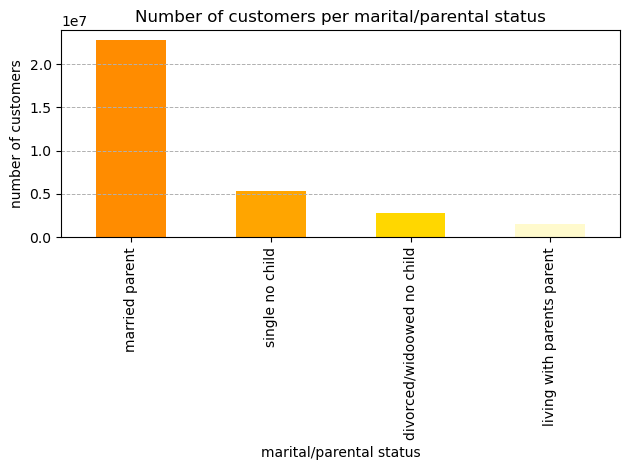

In [35]:
# create bar chart for the marital_parental_status profiles
bar_marketing = df['marital_parental_status'].value_counts().plot.bar(color =['darkorange','orange','gold','lemonchiffon'])

# add lables and title
plt.title('Number of customers per marital/parental status')
plt.xlabel('marital/parental status')
plt.ylabel('number of customers')

# add horizontal grid lines 
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# adjust layout to prevent labels from being cut off
plt.tight_layout()

# export the bar chart
bar_marketing.figure.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'marital_status.png'), bbox_inches='tight')

# display the plot
plt.show()

In [49]:
# create frequency df for the pie chart
social_class_freq = df['social_class'].value_counts()

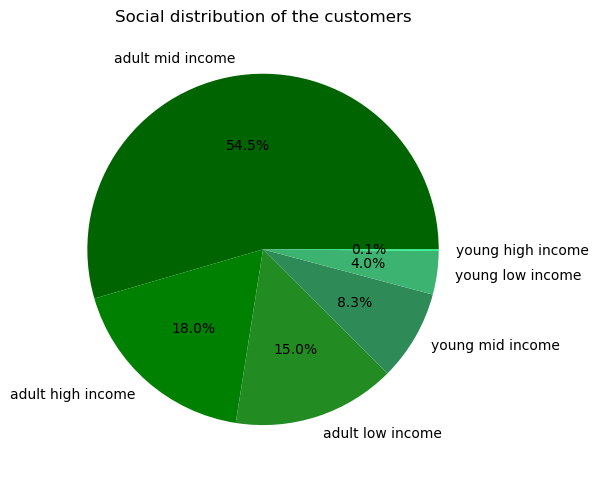

In [51]:
# create pie for the spocial_class flag
plt.figure(figsize=(6, 6))
plt.pie(social_class_freq, 

# add labels
labels = social_class_freq.index, 
autopct='%.1f%%',

# define tehe colours
colors = ['darkgreen', 'green', 'forestgreen', 'seagreen', 'mediumseagreen', 'springgreen']),
plt.title('Social distribution of the customers')

# adjust layout to prevent labels from being cut off 
plt.tight_layout()

# export the pie chart
plt.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'pie_spending.png'), bbox_inches='tight')

# display the plot
plt.show()

In [107]:
# aggregate the usage frequency by social_class
df.groupby('social_class').agg({'days_since_prior_order': ['mean', 'min', 'max']})

days_since_prior_order           
                                    mean  min   max
social_class                                       
adult high income              11.000657  0.0  30.0
adult low income               11.453131  0.0  30.0
adult mid income               11.045498  0.0  30.0
young high income              10.048335  0.0  30.0
young low income               11.331114  0.0  30.0
young mid income               10.995672  0.0  30.0

<b>Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.</b>

In [110]:
# aggregate the expenditure by social_class
df.groupby('social_class').agg({'prices': ['mean', 'min', 'max']})

prices              
                         mean  min      max
social_class                               
adult high income   24.115981  1.0  99999.0
adult low income     6.984381  1.0  14900.0
adult mid income     9.302134  1.0  99999.0
young high income  277.235898  1.0  99999.0
young low income     7.435245  1.0  14900.0
young mid income    10.349989  1.0  99999.0

<b>Compare your customer profiles with regions and departments. Can you identify a link between them? Customers may demonstrate different behaviors across regions, which could make this information important.</b>

In [64]:
# crosstab social_class / region
crosstab_social_region = pd.crosstab(df_final['social_class'], df_final['region'], dropna = False)

In [66]:
crosstab_social_region

region,Midwest,Northeast,South,West
social_class,,,,
adult high income,1384537,1042394,1908130,1499122
adult low income,1123557,858851,1649508,1228516
adult mid income,4149697,3110379,5857582,4547397
young high income,10942,4940,15545,10431
young low income,302878,223167,436130,337534
young mid income,625714,483005,924990,669913


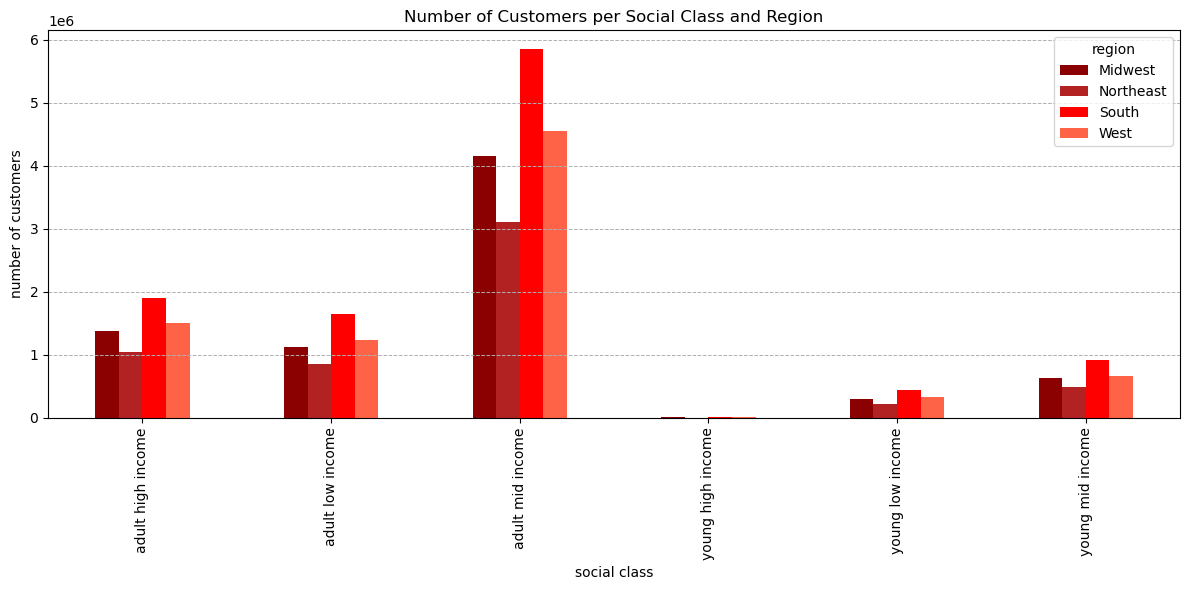

In [80]:
# bar visualisation of the comparison social_class / region
ax = crosstab_social_region.plot(kind='bar', stacked=False, figsize=(12, 6), color=['darkred', 'firebrick', 'red', 'tomato'])

# add title and labels 
ax.set_title('Number of Customers per Social Class and Region') 
ax.set_xlabel('social class')
ax.set_ylabel('number of customers') 

# add horizontal grid lines 
ax.grid(axis='y', linestyle='--', linewidth=0.7) 

# adjust layout to prevent labels from being cut off 
plt.tight_layout() 

# export the chart 
plt.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'customers_per_social_class_region.png'), bbox_inches='tight') 

# display the plot
plt.show()

In [82]:
# crosstab social_class / department
crosstab_social_dep = pd.crosstab(df_final['social_class'], df_final['department'], dropna = False)

In [83]:
crosstab_social_dep

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
social_class,,,,,,,,,,,,,,,,,,,,,
adult high income,31647,79996,219426,464787,123498,5633,201595,987173,189798,160981,...,135331,49715,137972,12592,6623,347739,80461,18935,1717671,451884
adult low income,25387,45511,159480,505868,124988,6222,129299,746807,154320,104184,...,121768,33778,63665,10006,5489,253434,68961,12323,1268779,703036
adult mid income,76251,245284,647096,1384381,365033,18296,603674,2989907,576631,491653,...,389894,151723,418437,37548,19512,1040401,242333,53163,5315237,1371686
young high income,1324,327,2072,3646,1136,5,1617,7441,1223,1278,...,1856,386,935,44,83,2721,836,251,7641,3463
young low income,5819,14421,45101,121862,30962,1378,39240,207630,42688,32284,...,30715,10558,23655,2846,1531,71621,18550,4174,354101,150477
young mid income,13268,38263,99253,207579,57416,3039,92633,459789,86589,76247,...,59102,23093,64263,6109,3053,159453,36431,8870,815862,207004


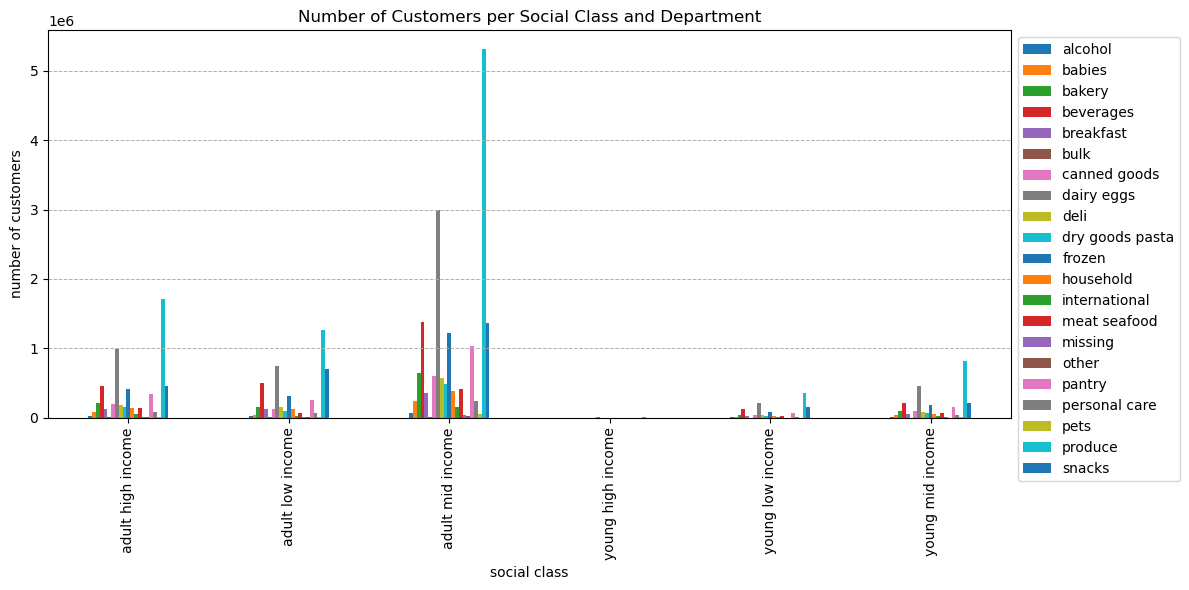

In [100]:
# Bar visualisation of the comparison social_class / department
ax = crosstab_social_dep.plot(kind = 'bar', stacked = False, figsize = (12, 6))

# add title and labels 
ax.set_title('Number of Customers per Social Class and Department') 
ax.set_xlabel('social class')
ax.set_ylabel('number of customers') 

# add horizontal grid lines 
ax.grid(axis = 'y', linestyle='--', linewidth=0.7) 

# positon the legend
ax.legend(loc= 'upper left', bbox_to_anchor =(1, 1))

# adjust layout to prevent labels from being cut off 
plt.tight_layout() 

# export the chart 
plt.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'customers_per_social_class_dep.png'), bbox_inches='tight') 

# display the plot
plt.show()

In [104]:
# crosstab mps / region
crosstab_mps_region = pd.crosstab(df_final['social_class'], df_final['region'], dropna = False)

In [84]:
crosstab_mps_region

region,Midwest,Northeast,South,West
marital_parental_status,,,,
divorced/widoowed no child,646401,501059,920849,703503
living with parents parent,366517,268114,529584,386388
married parent,5325608,4036321,7560642,5834182
single no child,1258799,917242,1780810,1368840


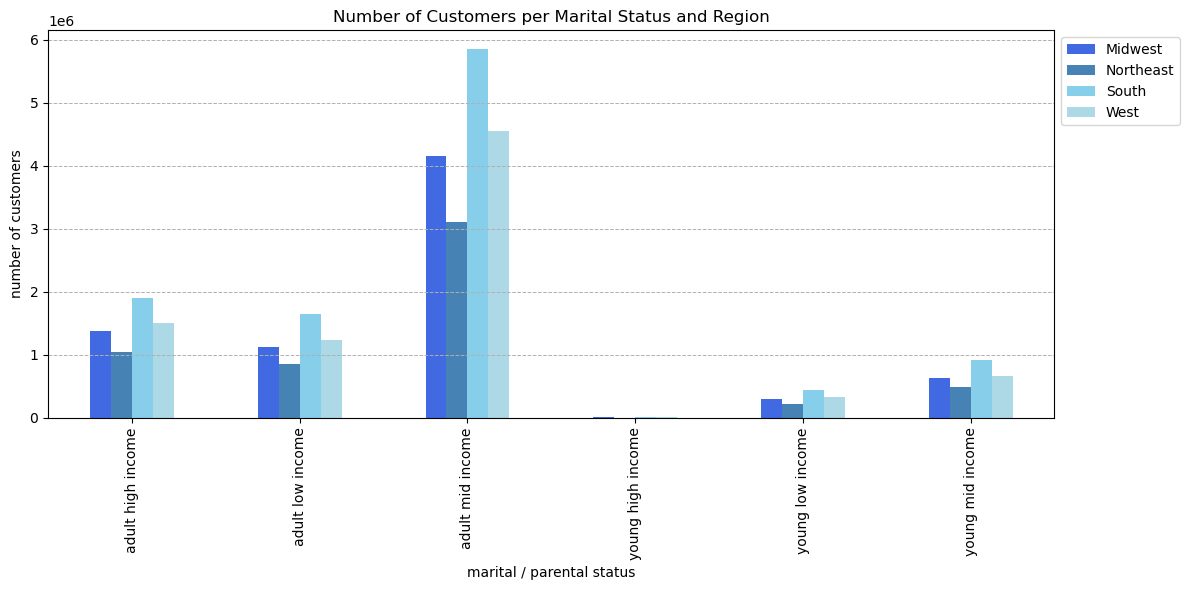

In [120]:
# Bar visualisation of the comparison mps /region
ax = crosstab_mps_region.plot( kind = 'bar', stacked = False, figsize = (12, 6), color = ['royalblue', 'steelblue', 'skyblue', 'lightblue'])

# add title and lables
ax.set_title('Number of Customers per Marital Status and Region')
ax.set_xlabel('marital / parental status')
ax.set_ylabel('number of customers')

# add horizontal grid lines 
ax.grid(axis = 'y', linestyle='--', linewidth=0.7)

# position the legend
ax.legend(loc= 'upper left', bbox_to_anchor =(1, 1))

# adjust layout to prevent labels from being cut off 
plt.tight_layout()

# export the bar
plt.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'customers_per_mps_region.png'), bbox_inches = 'tight')

# display the plot
plt.show()

In [124]:
# crosstab mps / department
crosstab_mps_dep = pd.crosstab(df_final['marital_parental_status'], df_final['department'], dropna = False)

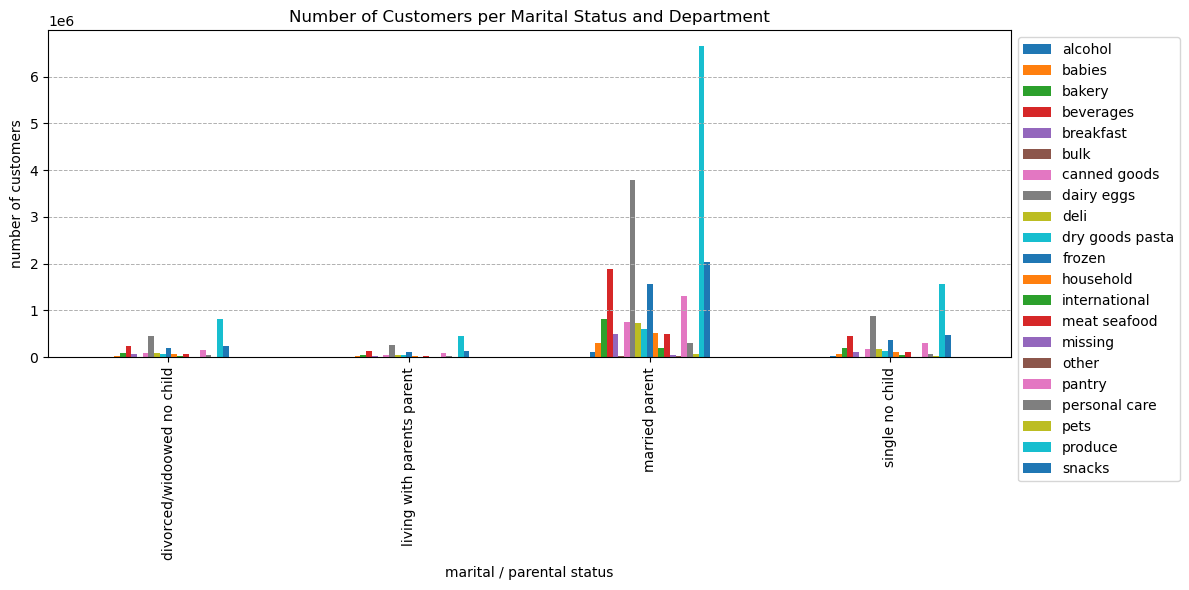

In [126]:
# Bar visualisation of the comparison mps /department
ax = crosstab_mps_dep.plot( kind = 'bar', stacked = False, figsize = (12, 6))

# add title and lables
ax.set_title('Number of Customers per Marital Status and Department')
ax.set_xlabel('marital / parental status')
ax.set_ylabel('number of customers')

# add horizontal grid lines 
ax.grid(axis = 'y', linestyle = '--', linewidth =0.7)

# position the legend
ax.legend(loc= 'upper left', bbox_to_anchor =(1, 1))

# adjust layout to prevent labels from being cut off 
plt.tight_layout()

# export the bar
plt.savefig(os.path.join(path, 'Analysis', 'Visualisations', 'mps_department.jpg'), bbox_inches = 'tight')

# display the plot
plt.show()

In [23]:
# export df_final
df_final.to_pickle(os.path.join(path, 'Data', 'Prepared', 'final_dataset.pkl'))